Requires SkyTools: `conda install skytools`

In [1]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
import skytools as st

Set paths on NERSC:

In [2]:
fg_path = f'/global/cfs/cdirs/cmb/gsharing/panexp_v1_planck/galactic_foregrounds_mediumcomplexity/'
npipe_path = f'/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/'

Read NPIPE map, create a mask from the polarized intensity.

In [10]:
hfi_npipe  = hp.read_map(f'{npipe_path}npipe6v20_353_map.fits', field=(0,1,2))  * 1e6
polI_npipe =np.sqrt(hfi_npipe[1]**2 + hfi_npipe[2]**2)
mask_G = st.intensity_mask(hp.get_nside(hfi_npipe), polI_npipe, 3., smooth_in_deg=1.)

rot = hp.Rotator(coord=['G','C'])
mask_C = rot.rotate_map_pixel(mask_G)

mask = st.mask_udgrade(mask_C, 128)


Read PySM simulation, apply `lmax=100` cut and smooth to 2 deg

In [11]:
freq = 353
lmax = 100
hfi_sim = st.change_resolution(hp.read_map(f'{fg_path}sobs_mbs-s0017-20250208_HFI_mission_{freq:03}_galactic_foregrounds_mediumcomplexity_healpix.fits', field=None)*mask_C, nside_out=128, lmax_sht=lmax, mode='iqu', fwhm_in=5., fwhm_out=2.) * mask

To the NPIPE map, apply `lmax=100` cut and smooth to 2 deg. Rotate the map to celestial.

In [12]:
freq = 353
lmax = 100
hfi_npp = st.change_resolution(hfi_npipe * mask_G, nside_out=128, lmax_sht=lmax, mode='iqu', fwhm_in=5., fwhm_out=2.)
rot = hp.Rotator(coord=['G','C'])
hfi_npp = rot.rotate_map_alms(hfi_npp, lmax=lmax) * mask

Compute polarized intensity

In [13]:
polI_sim = np.sqrt(hfi_sim[1]**2 + hfi_sim[2]**2)
polI_npp = np.sqrt(hfi_npp[1]**2 + hfi_npp[2]**2)

Make a mask based on NPIPE polarized intensity

In [6]:
mask = st.intensity_mask(128, polI_npp, 3., smooth_in_deg=1.)

Visualize the maps. There is ringing due to SHT and `lmax` clipping of the maps at 2048.

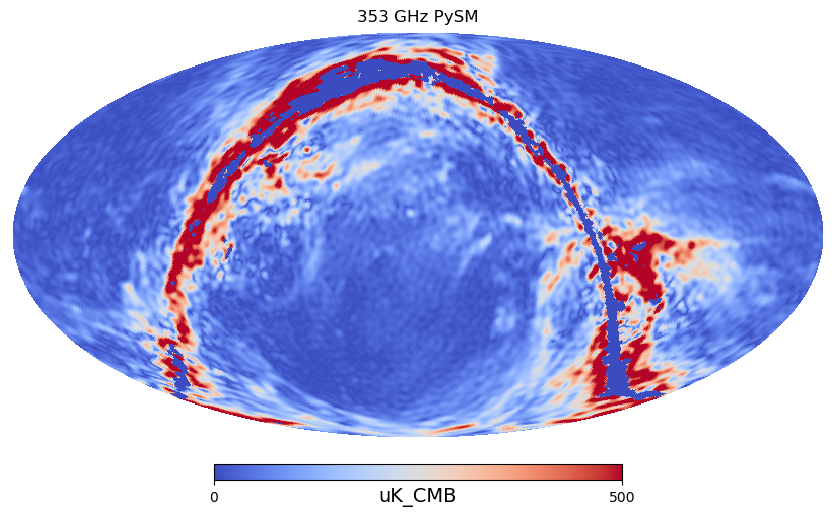

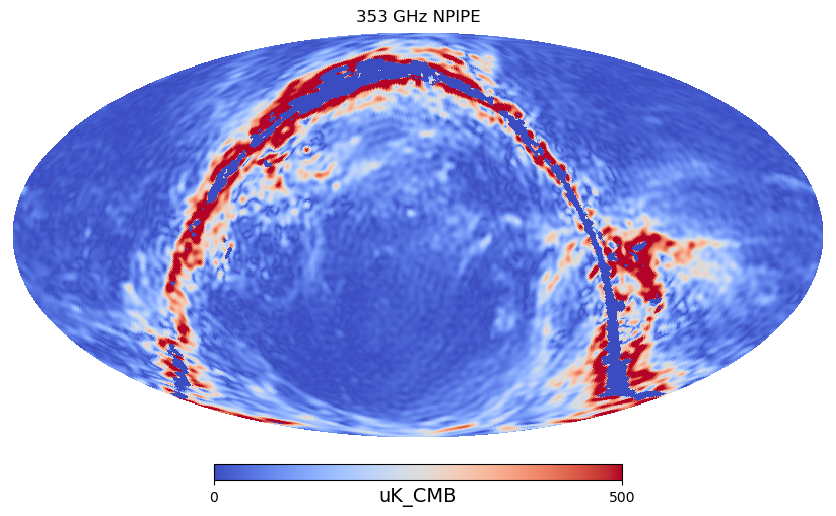

In [15]:
hp.mollview(polI_sim*mask, min=0, max=500, cmap='coolwarm', unit='uK_CMB', title=f'353 GHz PySM')
hp.mollview(polI_npp*mask, min=0, max=500, cmap='coolwarm', unit='uK_CMB', title=f'353 GHz NPIPE')

Scatter plot polarized intensity

Text(0, 0.5, 'PySM d10 353 GHz pol Intensity')

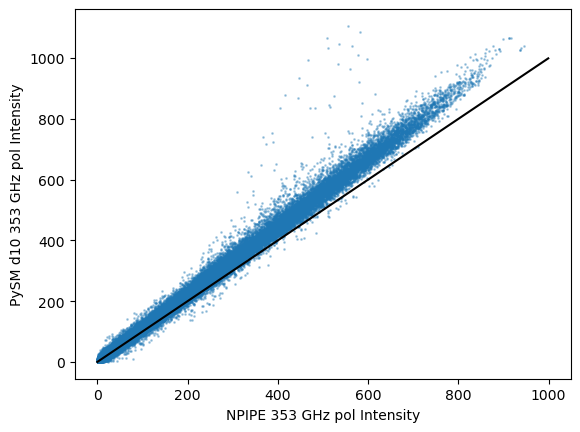

In [16]:
x = np.arange(0, 1000)
plt.plot(polI_npp[mask > 0.5], polI_sim[mask > 0.5], 'o', alpha=0.33, ms=1.0)
plt.plot(x, x, 'k-')
plt.xlabel('NPIPE 353 GHz pol Intensity')
plt.ylabel('PySM d10 353 GHz pol Intensity')


Compute B-modes:

In [17]:
Bmode_sim = st.iqu2teb(hfi_sim*mask, mode='b', lmax_sht=lmax)
Bmode_npp = st.iqu2teb(hfi_npp*mask, mode='b', lmax_sht=lmax)

Scatter plot for B-modes:

Text(0, 0.5, 'PySM d10 353 GHz B-mode map')

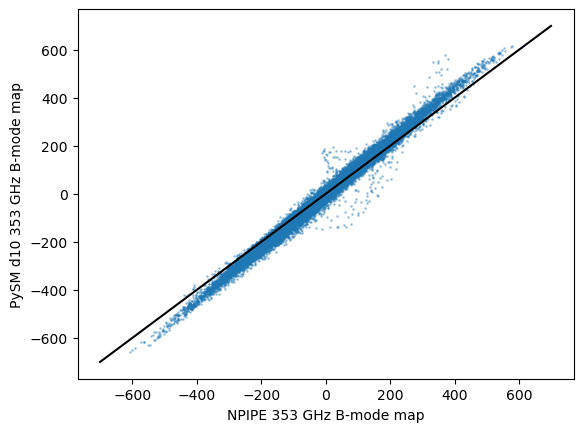

In [18]:
x = np.arange(-700, 700)
plt.plot(Bmode_npp[0, mask > 0.5], Bmode_sim[0, mask > 0.5], 'o', alpha=0.33, ms=1.0)
plt.plot(x, x, 'k-')
plt.xlabel('NPIPE 353 GHz B-mode map')
plt.ylabel('PySM d10 353 GHz B-mode map')